In this notebook, how to solve simple ODE using Physics Informed Neural Net with JAX(DL Framework).

Reference
- [Getting started with JAX (MLPs, CNNs & RNNs)](https://roberttlange.github.io/posts/2020/03/blog-post-10/)
- [Tutorials in postech "iai" lab website](https://iai.postech.ac.kr/tutorials)
- [Asem - Physics-informed-neural-network-in-JAX](https://github.com/ASEM000/Physics-informed-neural-network-in-JAX)

# Example 1.

### Given Conditions
- ODE: ${du \over dt} = cos 2\pi t$
- Initial Condition: $u(0) = 1$

### Exact Solution
- $u(t) = {1 \over 2 \pi} sin2 \pi t + 1$

### DL Approach
- Input: t (collocation points, not real data)
- NN: MLP (20 perceptrons for 4 layers)
- Output: $\hat u$
- Loss:
    - Governing Equation: $L_{ODE} = MSE({du \over dt} - cos 2\pi t, 0)$
    - Initial Condition: $L_{IC} = MSE(\hat u _{t = 0} , 1)$
    - Total Loss = $L_{total} = L_{ODE} + L_{IC}$


In [62]:
import time

import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad, random, nn
from jax.example_libraries import optimizers

import matplotlib.pyplot as plt

key = random.PRNGKey(seed=0)

In [ ]:
def target_func(t):
    return (jnp.sin(jnp.pi * 2 * t) / (2 * jnp.pi)) + 1

In [63]:
conditions_data_num = 1
collocation_points_data_num = 100

key = random.PRNGKey(seed=0)
collocation_points = random.uniform(
    key=key, 
    minval=0, maxval=2, 
    shape=(collocation_points_data_num, 1)
)


t_0 = jnp.zeros([conditions_data_num, 1])
# initial condition
# u(0) = 1 = DeviceArray([[1.]], dtype=float32)
ic_0 = jnp.ones([conditions_data_num, 1])

In [64]:
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        lb, ub = -(1 / jnp.sqrt(n)), (1 / jnp.sqrt(m))
        return lb + (ub-lb) *  random.uniform(w_key, (m, n)), random.uniform(b_key, (n,))

    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [1] + [20]*4 + [1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

In [65]:
def fwd(params, in_array):
    """ Compute the forward pass for each example individually """
    activations = in_array

    for w, b in params[:-1]:
        activations = nn.tanh(jnp.dot(activations, w) + b)

    # Perform final trafo to logits
    final_w, final_b = params[-1]
    output = jnp.dot(activations, final_w) + final_b
    return output

# Make a batched version of the `predict` function
fwd = vmap(fwd, in_axes=(None, 0), out_axes=0)

In [66]:
def ode_loss(t, u_t):
    return jnp.cos(2*jnp.pi*t) - u_t(t)


def loss_fun(params, colloc):
    t_c =colloc[:,[0]]

    loss = 0
    ufunc = lambda t : fwd(params,t)
    ufunc_t = lambda t:grad(lambda t:jnp.sum(ufunc(t)))(t)
    
    loss += jnp.mean(jnp.square(ode_loss(t_c, ufunc_t)))
    loss += jnp.mean(jnp.square(ic_0 - ufunc(t_0))) # ic_0

    return loss

In [67]:
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

@jit
def update(params, train_x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss_fun)(params, train_x)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state

In [68]:
epochs = 6_000

train_loss = []
for _ in range(epochs):
    params, opt_state = update(params, collocation_points, opt_state)

    # print loss and epoch info
    if _ %(1000) ==0:
        loss = loss_fun(params, collocation_points)
        train_loss.append(loss)
        print(f'Epoch={_}\tloss={loss:.3e}')

Epoch=0	loss=1.685e+01
Epoch=1000	loss=3.531e-01
Epoch=2000	loss=1.482e-01
Epoch=3000	loss=2.006e-04
Epoch=4000	loss=1.818e-04
Epoch=5000	loss=1.644e-04


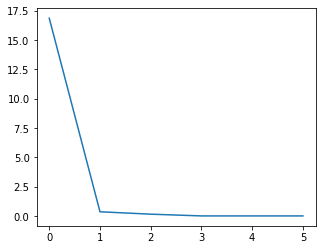

In [69]:
plt.figure(figsize = (5,4))
plt.plot(train_loss)
plt.show()

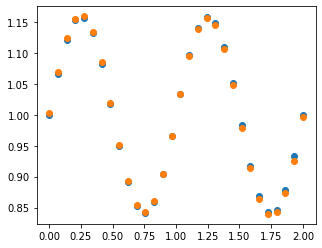

In [70]:
test_x = jnp.linspace(start=0, stop=2, num=30).reshape(-1, 1)
test_y = target_func(test_x)
pred_y = fwd(params, test_x)

plt.figure(figsize = (5,4))
plt.scatter(test_x, test_y)
plt.scatter(test_x, pred_y)
plt.show()

# Example 2.

### Given Conditions
- ODE: $-t cos(2 \pi t) + {d \over dt} y(t) + {d^2 \over dt^2}y(t) = 0$
- Initial Condition: $y(0) = 1$
- Boundary Condition: ${t \over dt} y(t) \mid _ {t=0} = 10$


### DL Approach
- Input: t (collocation points, not real data)
- NN: MLP (20 perceptrons for 4 layers)
- Output: $\hat y$
- Loss:
    - Governing Equation: $L_{ODE} = MSE(-t cos(2 \pi t) + {d \over dt} y(t) + {d^2 \over dt^2}y(t), 0)$
    - Initial Condition: $L_{IC} = MSE(\hat y _{t = 0} , 1)$
    - Boundary Condition: $L_{BC} = MSE({t \over dt} y(t) \mid _ {t=0}, 10)$
    - Total Loss = $L_{total} = L_{ODE} + L_{IC} + L{BC}$

In [ ]:
import time

import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad, random, nn
from jax.example_libraries import optimizers

import matplotlib.pyplot as plt

key = random.PRNGKey(seed=0)

In [ ]:
conditions_data_num = 1
collocation_points_data_num = 100

key = random.PRNGKey(seed=0)
collocation_points = random.uniform(
    key=key, 
    minval=0, maxval=jnp.pi, 
    shape=(collocation_points_data_num, 1)
)


t_0 = jnp.zeros([conditions_data_num, 1])
# initial condition
# u(0) = 1 = DeviceArray([[1.]], dtype=float32)
ic_0 = jnp.ones([conditions_data_num, 1])
# boundary condition
# u_t = 10 = DeviceArray([[10.]], dtype=float32)
bc_0 = jnp.ones([conditions_data_num, 1]) * 10

In [ ]:
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        lb, ub = -(1 / jnp.sqrt(n)), (1 / jnp.sqrt(m))
        return lb + (ub-lb) *  random.uniform(w_key, (m, n)), random.uniform(b_key, (n,))

    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [1] + [20]*4 + [1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

In [ ]:
def fwd(params, in_array):
    """ Compute the forward pass for each example individually """
    activations = in_array

    for w, b in params[:-1]:
        activations = nn.tanh(jnp.dot(activations, w) + b)

    # Perform final trafo to logits
    final_w, final_b = params[-1]
    output = jnp.dot(activations, final_w) + final_b
    return output

# Make a batched version of the `predict` function
fwd = vmap(fwd, in_axes=(None, 0), out_axes=0)

In [ ]:
def ode_loss(t,u):
    u_t = lambda t: grad(lambda t: jnp.sum(u(t)))(t)
    u_tt = lambda t :grad(lambda t : jnp.sum(u_t(t)))(t)
    return -t*jnp.cos(2*jnp.pi*t) + u_t(t) + u_tt(t)


def loss_fun(params, colloc):
    t_c =colloc[:,[0]]

    loss = 0
    ufunc = lambda t : fwd(params,t)
    ufunc_t = lambda t:grad(lambda t:jnp.sum(ufunc(t)))(t)
    
    loss += jnp.mean(ode_loss(t_c, ufunc)**2)
    loss += jnp.mean(jnp.square(ic_0 - ufunc(t_0))) # ic_0
    loss += jnp.mean(jnp.square(bc_0 - ufunc_t(t_0))) # bc_0

    return loss

In [ ]:
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

@jit
def update(params, train_x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss_fun)(params, train_x)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state

In [ ]:
epochs = 6_000

for _ in range(epochs):
    params, opt_state = update(params, collocation_points, opt_state)

    # print loss and epoch info
    if _ %(1000) ==0:
        print(f'Epoch={_}\tloss={loss_fun(params, collocation_points):.3e}')

Epoch=0	loss=1.182e+02
Epoch=1000	loss=1.879e+00
Epoch=2000	loss=1.824e+00
Epoch=3000	loss=1.389e+00
Epoch=4000	loss=2.978e-01
Epoch=5000	loss=3.693e-03


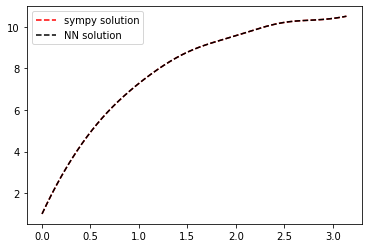

In [ ]:
import sympy as sp

t= sp.symbols('t')
f = sp.Function('y')
diffeq = sp.Eq(f(t).diff(t,t) + f(t).diff(t)-t*sp.cos(2*sp.pi*t),0)
sol = sp.simplify(sp.dsolve(diffeq,ics={f(0):1,f(t).diff(t).subs(t,0):10}).rhs)


lam_sol= sp.lambdify(t,sol)

dT = 1e-3
Tf = jnp.pi
T = np.arange(0,Tf+dT,dT)


sym_sol =np.array([lam_sol(i) for i in T])

plt.plot(T,sym_sol,'--r',label='sympy solution')
plt.plot(T,fwd(params,T.reshape(-1,1))[:,0],'--k',label='NN solution')
plt.legend()